In [87]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


print("[*] libs imported")

[*] libs imported


In [88]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
serving_df = pd.read_csv("/kaggle/input/titanic/test.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")

print("[*] data imported")

[*] data imported


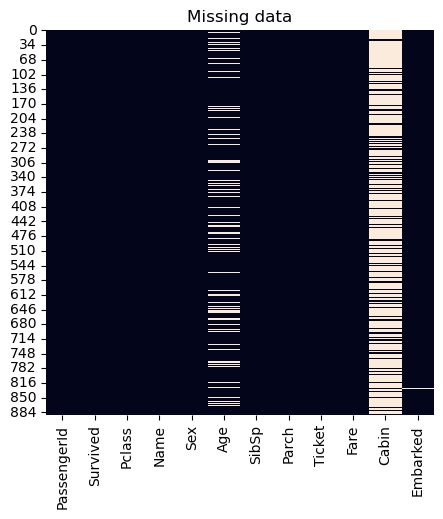

In [89]:
# Check if there features that are missing in the dataset
def missing_data(dataset):
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.title("Missing data")
    sns.heatmap(dataset.isnull(), cbar=False)
    
missing_data(train_df)

In [90]:
def stacked_bar(dataset, feature, stacked=True):
    survived = dataset[dataset['Survived']==1][feature].value_counts()
    dead = dataset[dataset['Survived']==0][feature].value_counts()
    df_survived_dead = pd.DataFrame([survived, dead])
    df_survived_dead.index = ['Survived passengers', 'Dead passengers']
    ax = df_survived_dead.plot(kind='bar', stacked=stacked, figsize=(5, 5))


0    0.616162
1    0.383838
Name: Survived, dtype: float64


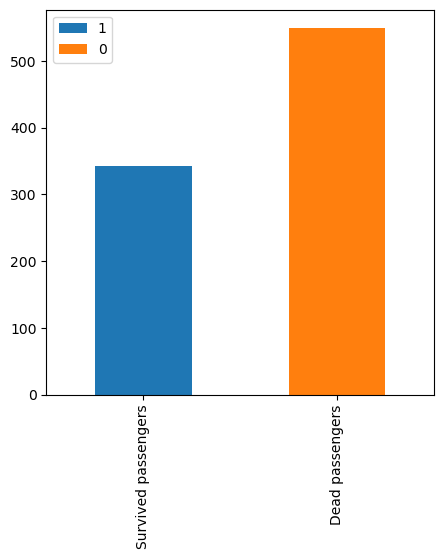

In [91]:
# Plot and examine the survived passengers
def survived_passengers(dataset, stacked=True):
    print(train_df['Survived'].value_counts(normalize=True))
    stacked_bar(dataset, "Survived")

    
survived_passengers(train_df)

        Sex
male    577
female  314
Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


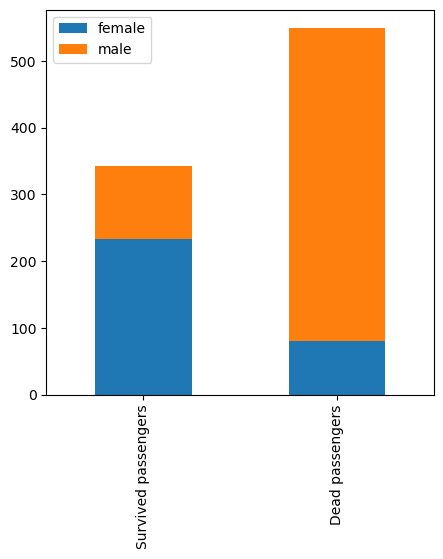

In [92]:
# Plot survived passengers depending on gender
def survived_gender(dataset, stacked=True):
    print(dataset['Sex'].value_counts().to_frame())
    print(dataset.groupby('Sex').Survived.mean())
    stacked_bar(dataset, "Sex")
    
survived_gender(train_df)

        Survived
Pclass          
1       0.629630
2       0.472826
3       0.242363


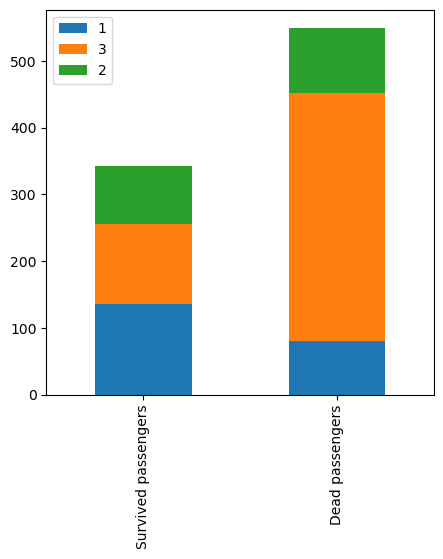

In [93]:
# Examine the class correlation to survival
def class_correlation(dataset):
    print(dataset.groupby(['Pclass']).Survived.mean().to_frame())
    stacked_bar(dataset, 'Pclass')

class_correlation(train_df)

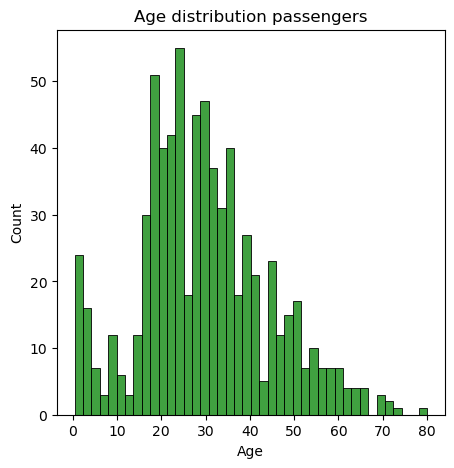

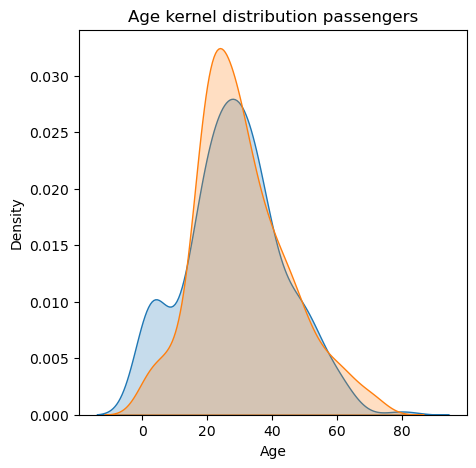

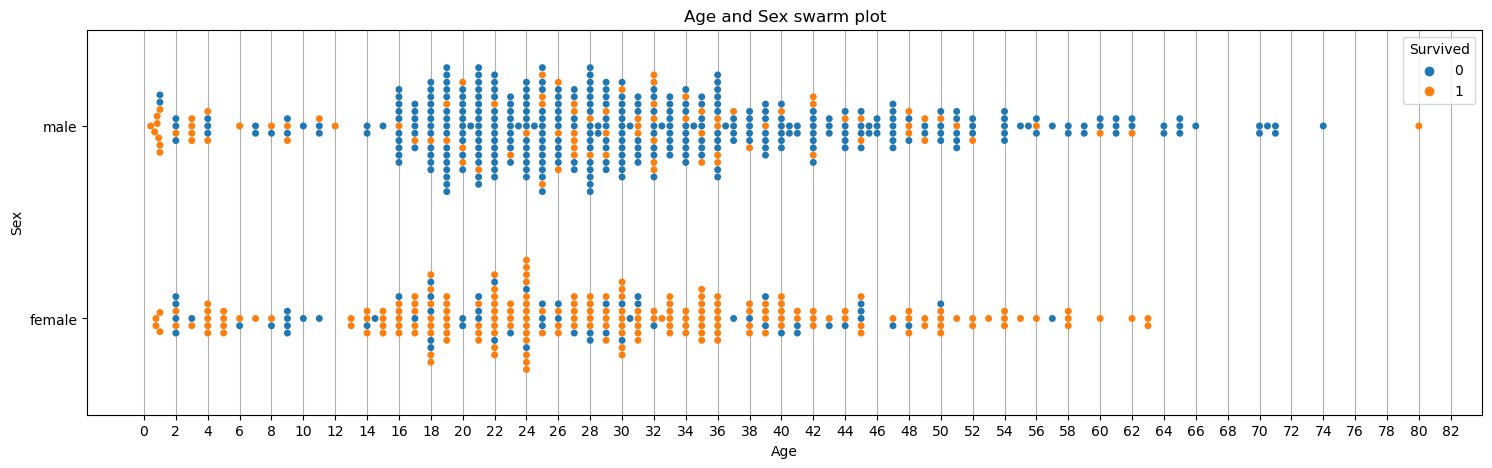

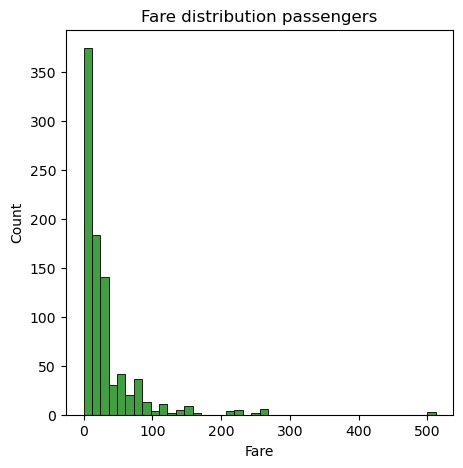

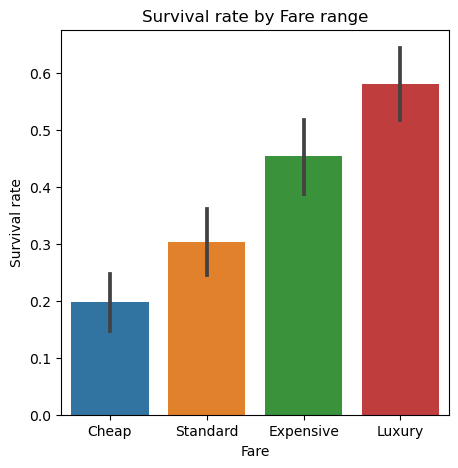

In [94]:
# Plot the age influence on surviving
def plt_dist(dataset, feature, title, bins=42, hist=True, fsize=(5, 5)):
    fig, ax = plt.subplots(figsize=fsize)
    ax.set_title(title)
    sns.histplot(dataset[feature], color='g', bins=bins, ax=ax)
    
def plot_kernel(dataset, feature, title, fsize=(5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    ax.set_title(title)
    sns.kdeplot(dataset[feature].loc[dataset["Survived"] == 1], fill=True, ax=ax,
               label='Survived').set_xlabel(feature)
    sns.kdeplot(dataset[feature].loc[dataset["Survived"] == 0], fill=True, ax=ax,
               label='Died')
    
def plot_swarm(dataset, feature1, feature2, title, fsize=(18,5)):
    fig, ax = plt.subplots(figsize=fsize)
    ax.set_title(title)
    ax.grid(True)
    plt.xticks(list(range(0,100,2)))
    sns.swarmplot(y=feature1, x=feature2, hue='Survived', data=dataset)
    
def plot_binning_quartiles(dataset, feature, title, categories):
    fig, ax = plt.subplots(figsize=(5, 5))
    fare_ranges = pd.qcut(dataset[feature], len(categories), labels=categories)
    ax.set_title(title)
    sns.barplot(x=fare_ranges, y=dataset.Survived, ax=ax).set_ylabel('Survival rate')
    
plt_dist(train_df, "Age", "Age distribution passengers")
plot_kernel(train_df, "Age", "Age kernel distribution passengers")
plot_swarm(train_df, "Sex", "Age", "Age and Sex swarm plot")
plt_dist(train_df, "Fare", "Fare distribution passengers")

categories = ['Cheap', 'Standard', 'Expensive', 'Luxury']
plot_binning_quartiles(train_df, "Fare", "Survival rate by Fare range", categories)

In [95]:
# Feature engineering
train = train_df.drop(['PassengerId', 'Ticket', 'Cabin'], axis = 1)
test = test_df.drop(['Ticket', 'Cabin'], axis = 1)
combine = [train, test]

for df in combine:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1


for df in combine:
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train['Title'], train['Sex'])

common = ['Master', 'Mr', 'Miss', 'Mrs']
for df in combine:
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['Title'] = [x if x in common else 'Rare' for x in df['Title']]


train['Title'].value_counts()
    

for df in combine:
    df['Sex'] = df['Sex'].map({'female': 0, 'male': 1})
    
title_ohe1 = pd.get_dummies(train['Title'], prefix = 'Title', drop_first = True)
train = pd.concat([train.drop('Title', axis = 1), title_ohe1], axis = 1)

title_ohe2 = pd.get_dummies(test['Title'], prefix = 'Title', drop_first = True)
test = pd.concat([test.drop('Title', axis = 1), title_ohe2], axis = 1)

train = train.drop(['Name', 'SibSp', 'Parch'], axis = 1)
test = test.drop(['Name', 'SibSp', 'Parch'], axis = 1)
combine = [train, test]

age_corr = train.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
age_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
age_corr[age_corr['Feature 1'] == 'Age']

impute_ages = np.zeros((2,3))
for df in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            impute_df = df[(df['Sex'] == i) & \
                                  (df['Pclass'] == j+1)]['Age'].dropna()
            impute_ages[i,j] = int(impute_df.median())
            
    for i in range(0, 2):
        for j in range(0, 3):
            df.loc[ (df.Age.isnull()) & (df.Sex == i) & (df.Pclass == j+1), 'Age'] = impute_ages[i,j]
            
impute_embarked= ['', '', '']
for df in combine:
    for i in range(0, 3):
        impute_val = df[df['Pclass'] == i+1]['Embarked'].dropna().mode()[0]
        impute_embarked[i] = impute_val
        
    for i in range(0, 3):
        df.loc[ (df.Embarked.isnull()) & (df.Pclass == i+1), 'Embarked'] = impute_embarked[i]
        
embarked_ohe1 = pd.get_dummies(train['Embarked'], prefix = 'Embarked', drop_first = True)
train = pd.concat([train.drop('Embarked', axis = 1), embarked_ohe1], axis = 1)

embarked_ohe2 = pd.get_dummies(test['Embarked'], prefix = 'Embarked', drop_first = True)
test = pd.concat([test.drop('Embarked', axis = 1), embarked_ohe2], axis = 1)

combine = [train, test]

imputer = SimpleImputer()
test['Fare'] = list(imputer.fit_transform(test[['Fare']]))
test['Fare'] = [x[0] for x in test['Fare']]

/tmp/ipykernel_32/2309118391.py:39: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  age_corr = train.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()


In [96]:
X = train.drop(columns = 'Survived')
X = pd.get_dummies(X, drop_first = True)

y = train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


def find_best_model(X_train, X_test, y_train, y_test):
    # Logistic Regression
    logreg = LogisticRegression(max_iter = 600, random_state = 42)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    logreg_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # Decision Tree
    decision_tree = DecisionTreeClassifier(random_state = 42)
    decision_tree.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_test)
    decision_tree_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # Random Forest
    random_forest = RandomForestClassifier(random_state = 42)
    random_forest.fit(X_train, y_train)
    y_pred = random_forest.predict(X_test)
    random_forest_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # XGBoost
    xgb = XGBClassifier(random_state = 42)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    xgb_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # GBM
    gbm = GradientBoostingClassifier(random_state = 42)
    gbm.fit(X_train, y_train)
    y_pred = gbm.predict(X_test)
    gbm_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # LightGBM
    lgbm = LGBMClassifier(random_state = 42)
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    lgbm_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
        
    # Catboost
    catb = CatBoostClassifier(verbose = 0, random_state = 42)
    catb.fit(X_train, y_train)
    y_pred = catb.predict(X_test)
    catb_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # Histogram-based Gradient Boosting Classification Tree
    hgb = HistGradientBoostingClassifier(random_state = 42)
    hgb.fit(X_train, y_train)
    y_pred = hgb.predict(X_test)
    hgb_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    model_df = pd.DataFrame({'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'GBM', 'LightGBM', 'Catboost', 'HistBoost'],
                       'Score': [logreg_acc, decision_tree_acc, random_forest_acc, xgb_acc, gbm_acc, lgbm_acc, catb_acc, hgb_acc]})
    print(model_df.sort_values('Score', ascending = False).reset_index(drop = True))


    
find_best_model(X_train, X_test, y_train, y_test)

                 Model  Score
0        Random Forest  84.92
1             LightGBM  84.36
2            HistBoost  84.36
3              XGBoost  83.80
4                  GBM  83.24
5             Catboost  83.24
6  Logistic Regression  79.89
7        Decision Tree  77.65


In [97]:
rfc = RandomForestClassifier(random_state=42, 
                             n_jobs=-1 # Use all cores on your machine
                            )
param_grid = { 
    'n_estimators': [100, 200, 300], # The number of boosting stages to perform
    'max_features': ['auto'], # The number of features to consider when looking for the best split
    'max_depth' : [4, 6, 8], # The maximum depth of the individual regression estimators.
    'criterion' :['gini', 'entropy'] #Function to measure the quality of a split
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring = 'accuracy', verbose = 10)
CV_rfc.fit(X, y)
print('')
print('Best hyperparameters:',CV_rfc.best_params_)

X_test = test.drop('PassengerId', axis = 1)
predictions = CV_rfc.predict(X_test)

output = pd.DataFrame({'PassengerId': test.PassengerId,
                      'Survived': predictions})

output.to_csv('titanic-submission.csv', index= False)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5; 1/18] START criterion=gini, max_depth=4, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 1/18] END criterion=gini, max_depth=4, max_features=auto, n_estimators=100;, score=0.844 total time=   0.3s
[CV 2/5; 1/18] START criterion=gini, max_depth=4, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 1/18] END criterion=gini, max_depth=4, max_features=auto, n_estimators=100;, score=0.820 total time=   0.3s
[CV 3/5; 1/18] START criterion=gini, max_depth=4, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 1/18] END criterion=gini, max_depth=4, max_features=auto, n_estimators=100;, score=0.826 total time=   0.3s
[CV 4/5; 1/18] START criterion=gini, max_depth=4, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 1/18] END criterion=gini, max_depth=4, max_features=auto, n_estimators=100;, score=0.798 total time=   0.3s
[CV 5/5; 1/18] START criterion=gini, max_depth=4, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 1/18] END criterion=gini, max_depth=4, max_features=auto, n_estimators=100;, score=0.843 total time=   0.3s
[CV 1/5; 2/18] START criterion=gini, max_depth=4, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 2/18] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.844 total time=   0.5s
[CV 2/5; 2/18] START criterion=gini, max_depth=4, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 2/18] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.820 total time=   0.5s
[CV 3/5; 2/18] START criterion=gini, max_depth=4, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 2/18] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.826 total time=   0.5s
[CV 4/5; 2/18] START criterion=gini, max_depth=4, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 2/18] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.798 total time=   0.5s
[CV 5/5; 2/18] START criterion=gini, max_depth=4, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 2/18] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.843 total time=   0.5s
[CV 1/5; 3/18] START criterion=gini, max_depth=4, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 3/18] END criterion=gini, max_depth=4, max_features=auto, n_estimators=300;, score=0.849 total time=   0.8s
[CV 2/5; 3/18] START criterion=gini, max_depth=4, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 3/18] END criterion=gini, max_depth=4, max_features=auto, n_estimators=300;, score=0.820 total time=   0.8s
[CV 3/5; 3/18] START criterion=gini, max_depth=4, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 3/18] END criterion=gini, max_depth=4, max_features=auto, n_estimators=300;, score=0.826 total time=   0.8s
[CV 4/5; 3/18] START criterion=gini, max_depth=4, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 3/18] END criterion=gini, max_depth=4, max_features=auto, n_estimators=300;, score=0.798 total time=   0.8s
[CV 5/5; 3/18] START criterion=gini, max_depth=4, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 3/18] END criterion=gini, max_depth=4, max_features=auto, n_estimators=300;, score=0.848 total time=   0.8s
[CV 1/5; 4/18] START criterion=gini, max_depth=6, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 4/18] END criterion=gini, max_depth=6, max_features=auto, n_estimators=100;, score=0.838 total time=   0.3s
[CV 2/5; 4/18] START criterion=gini, max_depth=6, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 4/18] END criterion=gini, max_depth=6, max_features=auto, n_estimators=100;, score=0.820 total time=   0.3s
[CV 3/5; 4/18] START criterion=gini, max_depth=6, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 4/18] END criterion=gini, max_depth=6, max_features=auto, n_estimators=100;, score=0.826 total time=   0.3s
[CV 4/5; 4/18] START criterion=gini, max_depth=6, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 4/18] END criterion=gini, max_depth=6, max_features=auto, n_estimators=100;, score=0.792 total time=   0.3s
[CV 5/5; 4/18] START criterion=gini, max_depth=6, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 4/18] END criterion=gini, max_depth=6, max_features=auto, n_estimators=100;, score=0.831 total time=   0.3s
[CV 1/5; 5/18] START criterion=gini, max_depth=6, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 5/18] END criterion=gini, max_depth=6, max_features=auto, n_estimators=200;, score=0.832 total time=   0.6s
[CV 2/5; 5/18] START criterion=gini, max_depth=6, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 5/18] END criterion=gini, max_depth=6, max_features=auto, n_estimators=200;, score=0.809 total time=   0.6s
[CV 3/5; 5/18] START criterion=gini, max_depth=6, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 5/18] END criterion=gini, max_depth=6, max_features=auto, n_estimators=200;, score=0.826 total time=   0.6s
[CV 4/5; 5/18] START criterion=gini, max_depth=6, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 5/18] END criterion=gini, max_depth=6, max_features=auto, n_estimators=200;, score=0.798 total time=   0.5s
[CV 5/5; 5/18] START criterion=gini, max_depth=6, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 5/18] END criterion=gini, max_depth=6, max_features=auto, n_estimators=200;, score=0.831 total time=   0.5s
[CV 1/5; 6/18] START criterion=gini, max_depth=6, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 6/18] END criterion=gini, max_depth=6, max_features=auto, n_estimators=300;, score=0.832 total time=   0.8s
[CV 2/5; 6/18] START criterion=gini, max_depth=6, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 6/18] END criterion=gini, max_depth=6, max_features=auto, n_estimators=300;, score=0.815 total time=   0.8s
[CV 3/5; 6/18] START criterion=gini, max_depth=6, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 6/18] END criterion=gini, max_depth=6, max_features=auto, n_estimators=300;, score=0.831 total time=   0.8s
[CV 4/5; 6/18] START criterion=gini, max_depth=6, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 6/18] END criterion=gini, max_depth=6, max_features=auto, n_estimators=300;, score=0.792 total time=   0.8s
[CV 5/5; 6/18] START criterion=gini, max_depth=6, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 6/18] END criterion=gini, max_depth=6, max_features=auto, n_estimators=300;, score=0.831 total time=   0.8s
[CV 1/5; 7/18] START criterion=gini, max_depth=8, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 7/18] END criterion=gini, max_depth=8, max_features=auto, n_estimators=100;, score=0.838 total time=   0.3s
[CV 2/5; 7/18] START criterion=gini, max_depth=8, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 7/18] END criterion=gini, max_depth=8, max_features=auto, n_estimators=100;, score=0.803 total time=   0.3s
[CV 3/5; 7/18] START criterion=gini, max_depth=8, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 7/18] END criterion=gini, max_depth=8, max_features=auto, n_estimators=100;, score=0.860 total time=   0.3s
[CV 4/5; 7/18] START criterion=gini, max_depth=8, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 7/18] END criterion=gini, max_depth=8, max_features=auto, n_estimators=100;, score=0.798 total time=   0.3s
[CV 5/5; 7/18] START criterion=gini, max_depth=8, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 7/18] END criterion=gini, max_depth=8, max_features=auto, n_estimators=100;, score=0.820 total time=   0.3s
[CV 1/5; 8/18] START criterion=gini, max_depth=8, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 8/18] END criterion=gini, max_depth=8, max_features=auto, n_estimators=200;, score=0.838 total time=   0.6s
[CV 2/5; 8/18] START criterion=gini, max_depth=8, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 8/18] END criterion=gini, max_depth=8, max_features=auto, n_estimators=200;, score=0.809 total time=   0.6s
[CV 3/5; 8/18] START criterion=gini, max_depth=8, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 8/18] END criterion=gini, max_depth=8, max_features=auto, n_estimators=200;, score=0.865 total time=   0.6s
[CV 4/5; 8/18] START criterion=gini, max_depth=8, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 8/18] END criterion=gini, max_depth=8, max_features=auto, n_estimators=200;, score=0.798 total time=   0.6s
[CV 5/5; 8/18] START criterion=gini, max_depth=8, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 8/18] END criterion=gini, max_depth=8, max_features=auto, n_estimators=200;, score=0.826 total time=   0.6s
[CV 1/5; 9/18] START criterion=gini, max_depth=8, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 9/18] END criterion=gini, max_depth=8, max_features=auto, n_estimators=300;, score=0.838 total time=   0.8s
[CV 2/5; 9/18] START criterion=gini, max_depth=8, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 9/18] END criterion=gini, max_depth=8, max_features=auto, n_estimators=300;, score=0.809 total time=   0.9s
[CV 3/5; 9/18] START criterion=gini, max_depth=8, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 9/18] END criterion=gini, max_depth=8, max_features=auto, n_estimators=300;, score=0.854 total time=   0.8s
[CV 4/5; 9/18] START criterion=gini, max_depth=8, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 9/18] END criterion=gini, max_depth=8, max_features=auto, n_estimators=300;, score=0.792 total time=   0.8s
[CV 5/5; 9/18] START criterion=gini, max_depth=8, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 9/18] END criterion=gini, max_depth=8, max_features=auto, n_estimators=300;, score=0.826 total time=   0.8s
[CV 1/5; 10/18] START criterion=entropy, max_depth=4, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 10/18] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=100;, score=0.838 total time=   0.3s
[CV 2/5; 10/18] START criterion=entropy, max_depth=4, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 10/18] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=100;, score=0.826 total time=   0.3s
[CV 3/5; 10/18] START criterion=entropy, max_depth=4, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 10/18] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=100;, score=0.826 total time=   0.3s
[CV 4/5; 10/18] START criterion=entropy, max_depth=4, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 10/18] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=100;, score=0.798 total time=   0.3s
[CV 5/5; 10/18] START criterion=entropy, max_depth=4, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 10/18] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=100;, score=0.843 total time=   0.3s
[CV 1/5; 11/18] START criterion=entropy, max_depth=4, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 11/18] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=200;, score=0.838 total time=   0.5s
[CV 2/5; 11/18] START criterion=entropy, max_depth=4, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 11/18] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=200;, score=0.820 total time=   0.5s
[CV 3/5; 11/18] START criterion=entropy, max_depth=4, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 11/18] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=200;, score=0.826 total time=   0.5s
[CV 4/5; 11/18] START criterion=entropy, max_depth=4, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 11/18] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=200;, score=0.798 total time=   0.5s
[CV 5/5; 11/18] START criterion=entropy, max_depth=4, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 11/18] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=200;, score=0.843 total time=   0.5s
[CV 1/5; 12/18] START criterion=entropy, max_depth=4, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 12/18] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=300;, score=0.832 total time=   0.8s
[CV 2/5; 12/18] START criterion=entropy, max_depth=4, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 12/18] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=300;, score=0.820 total time=   0.8s
[CV 3/5; 12/18] START criterion=entropy, max_depth=4, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 12/18] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=300;, score=0.826 total time=   0.8s
[CV 4/5; 12/18] START criterion=entropy, max_depth=4, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 12/18] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=300;, score=0.798 total time=   0.8s
[CV 5/5; 12/18] START criterion=entropy, max_depth=4, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 12/18] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=300;, score=0.848 total time=   0.8s
[CV 1/5; 13/18] START criterion=entropy, max_depth=6, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 13/18] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=100;, score=0.838 total time=   0.3s
[CV 2/5; 13/18] START criterion=entropy, max_depth=6, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 13/18] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=100;, score=0.826 total time=   0.3s
[CV 3/5; 13/18] START criterion=entropy, max_depth=6, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 13/18] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=100;, score=0.826 total time=   0.3s
[CV 4/5; 13/18] START criterion=entropy, max_depth=6, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 13/18] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=100;, score=0.792 total time=   0.3s
[CV 5/5; 13/18] START criterion=entropy, max_depth=6, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 13/18] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=100;, score=0.831 total time=   0.3s
[CV 1/5; 14/18] START criterion=entropy, max_depth=6, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 14/18] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=200;, score=0.838 total time=   0.6s
[CV 2/5; 14/18] START criterion=entropy, max_depth=6, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 14/18] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=200;, score=0.820 total time=   0.6s
[CV 3/5; 14/18] START criterion=entropy, max_depth=6, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 14/18] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=200;, score=0.826 total time=   0.6s
[CV 4/5; 14/18] START criterion=entropy, max_depth=6, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 14/18] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=200;, score=0.798 total time=   0.6s
[CV 5/5; 14/18] START criterion=entropy, max_depth=6, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 14/18] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=200;, score=0.837 total time=   0.6s
[CV 1/5; 15/18] START criterion=entropy, max_depth=6, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 15/18] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=300;, score=0.832 total time=   0.8s
[CV 2/5; 15/18] START criterion=entropy, max_depth=6, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 15/18] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=300;, score=0.826 total time=   0.8s
[CV 3/5; 15/18] START criterion=entropy, max_depth=6, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 15/18] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=300;, score=0.826 total time=   0.8s
[CV 4/5; 15/18] START criterion=entropy, max_depth=6, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 15/18] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=300;, score=0.798 total time=   0.8s
[CV 5/5; 15/18] START criterion=entropy, max_depth=6, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 15/18] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=300;, score=0.843 total time=   0.8s
[CV 1/5; 16/18] START criterion=entropy, max_depth=8, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 16/18] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=100;, score=0.832 total time=   0.3s
[CV 2/5; 16/18] START criterion=entropy, max_depth=8, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 16/18] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=100;, score=0.809 total time=   0.3s
[CV 3/5; 16/18] START criterion=entropy, max_depth=8, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 16/18] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=100;, score=0.860 total time=   0.3s
[CV 4/5; 16/18] START criterion=entropy, max_depth=8, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 16/18] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=100;, score=0.787 total time=   0.3s
[CV 5/5; 16/18] START criterion=entropy, max_depth=8, max_features=auto, n_estimators=100


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 16/18] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=100;, score=0.815 total time=   0.3s
[CV 1/5; 17/18] START criterion=entropy, max_depth=8, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 17/18] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=200;, score=0.832 total time=   0.6s
[CV 2/5; 17/18] START criterion=entropy, max_depth=8, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 17/18] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=200;, score=0.809 total time=   0.6s
[CV 3/5; 17/18] START criterion=entropy, max_depth=8, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 17/18] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=200;, score=0.854 total time=   0.6s
[CV 4/5; 17/18] START criterion=entropy, max_depth=8, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 17/18] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=200;, score=0.798 total time=   0.6s
[CV 5/5; 17/18] START criterion=entropy, max_depth=8, max_features=auto, n_estimators=200


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 17/18] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=200;, score=0.820 total time=   0.6s
[CV 1/5; 18/18] START criterion=entropy, max_depth=8, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 18/18] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=300;, score=0.832 total time=   0.8s
[CV 2/5; 18/18] START criterion=entropy, max_depth=8, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 18/18] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=300;, score=0.809 total time=   0.8s
[CV 3/5; 18/18] START criterion=entropy, max_depth=8, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 18/18] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=300;, score=0.843 total time=   0.8s
[CV 4/5; 18/18] START criterion=entropy, max_depth=8, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 18/18] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=300;, score=0.798 total time=   0.8s
[CV 5/5; 18/18] START criterion=entropy, max_depth=8, max_features=auto, n_estimators=300


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 18/18] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=300;, score=0.826 total time=   0.9s


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



Best hyperparameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 300}
